<a href="https://colab.research.google.com/github/TheRadDani/tpuAcceleratedCNN/blob/main/tpuAcceleratedCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
tf.keras.backend.clear_session()

List of physical devices

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Display TPU device if connected

In [4]:
import os

if 'COLAB_TPU_ADDR' in os.environ:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', tpu_address)
else:
  print('Not connected to a TPU runtime.')

TPU address is grpc://10.32.69.2:8470


Load and preprocess data to train the model

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generator for augmentation
data_generator = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess data
x_train = x_train.reshape((60000, 28, 28, 1)).astype('float32') / 255.0
x_test = x_test.reshape((10000, 28, 28, 1)).astype('float32') / 255.0

# Define batch size and number of classes
batch_size = 128
num_classes = 10

# Fit data generator to training data
data_generator.fit(x_train)

# Create TPU strategy
if 'COLAB_TPU_ADDR' in os.environ:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu_address)
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)

global_batch_size = batch_size * strategy.num_replicas_in_sync

# Create augmented datasets
train_augmented = data_generator.flow(x_train, y_train, batch_size=global_batch_size)
test_augmented = data_generator.flow(x_test, y_test, batch_size=global_batch_size)

# Wrap generators in tf.data.Dataset objects and apply map function
train_dataset = tf.data.Dataset.from_generator(lambda: train_augmented,
                 output_types=(tf.float32, tf.int32),
                 output_shapes=([28, 28], [global_batch_size]))
test_dataset = tf.data.Dataset.from_generator(lambda: test_augmented,
                 output_types=(tf.float32, tf.int32),
                 output_shapes=([28, 28], [global_batch_size]))

train_dataset = train_dataset.shuffle(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(1024)

# Configure datasets for distributed training
train_dataset = train_dataset.batch(global_batch_size).repeat()
test_dataset = test_dataset.batch(global_batch_size).repeat()

Visualize data

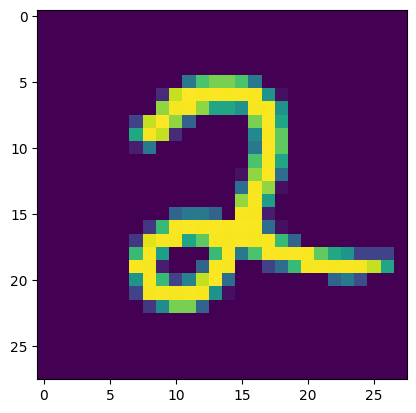

In [25]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(x_train[np.random.randint(x_train.shape[0])+1])
plt.show()

In [33]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
# Define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# connect to TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address)
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# distribute the dataset and model
strategy = tf.distribute.TPUStrategy(tpu)

# Define model
with strategy.scope():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        #batch normalization layer to speed up trainig
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
epochs = 10
with strategy.scope():
    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            pred = model(x)
            loss = model.compiled_loss(y, pred)
        grads = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        model.compiled_metrics.update_state(y, pred)
        return {m.name: m.result() for m in model.metrics}
    
    @tf.function
    def test_step(x, y):
        pred = model(x)
        loss = model.compiled_loss(y, pred)
        model.compiled_metrics.update_state(y, pred)
        return {m.name: m.result() for m in model.metrics}
    
    history = model.fit(train_dataset.repeat(), 
                        epochs=epochs, 
                        validation_data=test_dataset.repeat(),
                        callbacks=[early_stop],  # Pass the early stopping callback to the fit method
                        verbose=2,
                        steps_per_epoch=len(x_train)//batch_size,
                        validation_steps=len(x_test)//batch_size,
                        )  # repeat the datasets indefinitely to avoid "Unknown shape" errors

Epoch 1/10


OutOfRangeError: ignored

train dataset batch

In [17]:
# Get the number of elements
num_batches = train_dataset.cardinality().numpy()
num_elements = num_batches * batch_size
print("Number of elements: ", num_elements)

Number of elements:  60032


test dataset batch

In [18]:
# Get the number of elements
num_batches = test_dataset.cardinality().numpy()
num_elements = num_batches * batch_size
print("Number of elements: ", num_elements)

Number of elements:  10112


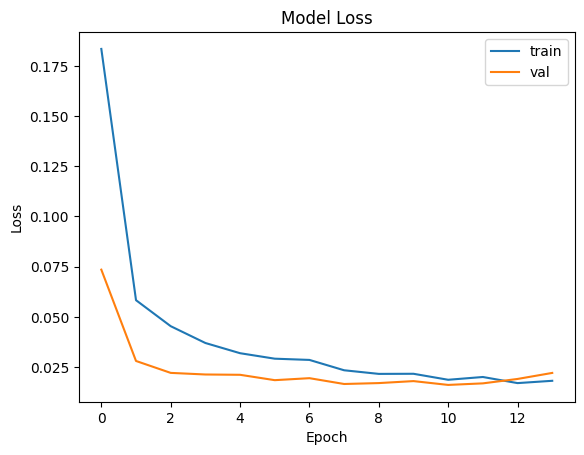

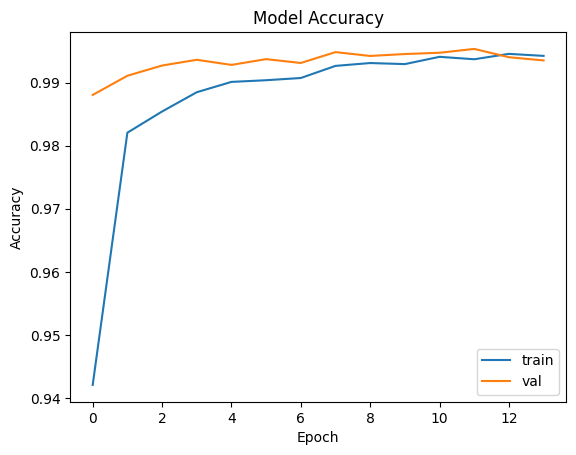

In [24]:
import matplotlib.pyplot as plt
# Plot the loss and accuracy curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

Save model in google colab

In [21]:
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/tpu_cnn.h5'
model.save('tpu_cnn.h5')

Mounted at /content/drive


Load .h5 model

In [4]:
from google.colab import drive
drive.mount('/content/drive')
load_path = '/content/drive/MyDrive/tpu_cnn.h5'
from tensorflow import keras

loaded_model = keras.models.load_model(load_path)

Mounted at /content/drive


Data augmentation technique for model inference

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define data augmentation
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
# Generate new data
generated_data = datagen.flow(x_test, y_test, batch_size=128)

free disc

In [6]:
!df -h
!free -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   24G   85G  22% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.1G  841M  58% /usr/sbin/docker-init
tmpfs           6.4G   80K  6.4G   1% /var/colab
/dev/sda1        70G   42G   28G  61% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G     0   15G   0% /content/drive
              total        used        free      shared  buff/cache   available
Mem:           12Gi       1.7Gi       6.6Gi       1.0Mi       4.3Gi        10Gi
Swap:            0B          0B          0B


In [7]:
predictions = loaded_model.predict(generated_data)

# Print the predictions
print(predictions)

79/79 [==============================] - 6s 75ms/step
[[4.2321167e-07 9.9818171e-05 6.4640739e-03 ... 2.2033567e-03
  2.1288784e-05 1.8503843e-02]
 [4.0419954e-01 4.0958837e-01 1.7499362e-01 ... 6.3384613e-03
  3.0770877e-03 4.9830520e-05]
 [2.9536736e-08 3.4470061e-13 4.5295204e-12 ... 2.2472065e-13
  1.3768193e-09 1.0285376e-10]
 ...
 [5.6203489e-06 1.2068638e-05 7.1819130e-05 ... 4.3510858e-02
  2.6211099e-05 9.5428693e-01]
 [5.4832462e-06 4.4279193e-05 3.8881744e-06 ... 7.9895242e-04
  1.1332231e-02 1.0507224e-01]
 [8.2162096e-08 6.1935600e-05 1.9988016e-05 ... 4.9123400e-08
  3.4230504e-06 8.6421707e-08]]


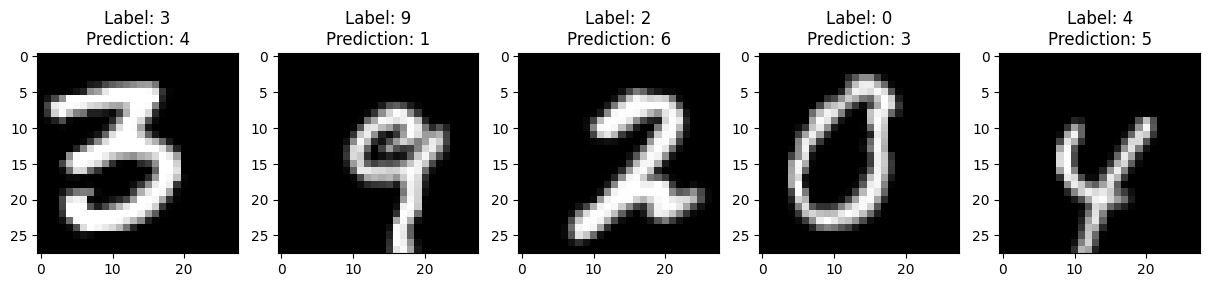

In [8]:
import numpy as np
import matplotlib.pyplot as plt

images, labels = next(generated_data) # get the first batch
# Define a mapping from label index to label name
label_names = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'
]
# Plot the images and predictions
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for i in range(5):
    image = images[i].reshape(28, 28)
    label = label_names[labels[i]]
    prediction = label_names[np.argmax(predictions[i])]
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}\nPrediction: {prediction}")
plt.show()